# Load and Analyze Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import sklearn
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import std
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import umap
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import mean_squared_error 
from keras.callbacks import ModelCheckpoint
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.manifold import TSNE
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Type
style_talk = 'seaborn-talk'    #refer to plt.style.available
random.seed(101)
np.random.seed(101)
%matplotlib inline

In [2]:
class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

"""

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

In [3]:
df = pd.read_csv("qsar_fish_toxicity.csv", delimiter = ";", names = ["CIC0", "SM1_Dz", "GATS1i", "NdsCH", "NdssC", "MLOGP", "LC50"])
df.shape

(908, 7)

In [4]:
df.head()

,CIC0,SM1_Dz,GATS1i,NdsCH,NdssC,MLOGP,LC50
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [5]:
df.tail()

,CIC0,SM1_Dz,GATS1i,NdsCH,NdssC,MLOGP,LC50
903,2.801,0.728,2.226,0,2,0.736,3.109
904,3.652,0.872,0.867,2,3,3.983,4.040
905,3.763,0.916,0.878,0,6,2.918,4.818
906,2.831,1.393,1.077,0,1,0.906,5.317
907,4.057,1.032,1.183,1,3,4.754,8.201


In [6]:
df.describe()

,CIC0,SM1_Dz,GATS1i,NdsCH,NdssC,MLOGP,LC50
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,2.898129,0.628468,1.293591,0.229075,0.485683,2.109285,4.064431
std,0.756088,0.428459,0.394303,0.605335,0.861279,1.433181,1.455698
min,0.667000,0.000000,0.396000,0.000000,0.000000,-2.884000,0.053000
25%,2.347000,0.223000,0.950750,0.000000,0.000000,1.209000,3.151750
50%,2.934000,0.570000,1.240500,0.000000,0.000000,2.127000,3.987500
75%,3.407000,0.892750,1.562250,0.000000,1.000000,3.105000,4.907500
max,5.926000,2.171000,2.920000,4.000000,6.000000,6.515000,9.612000


<AxesSubplot:>

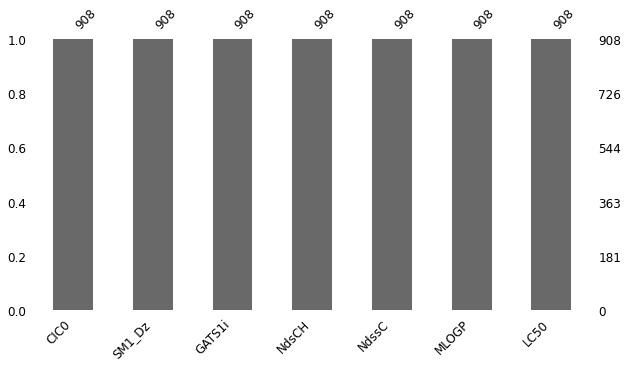

In [7]:
msno.bar(df, figsize=(10,5), fontsize=12)

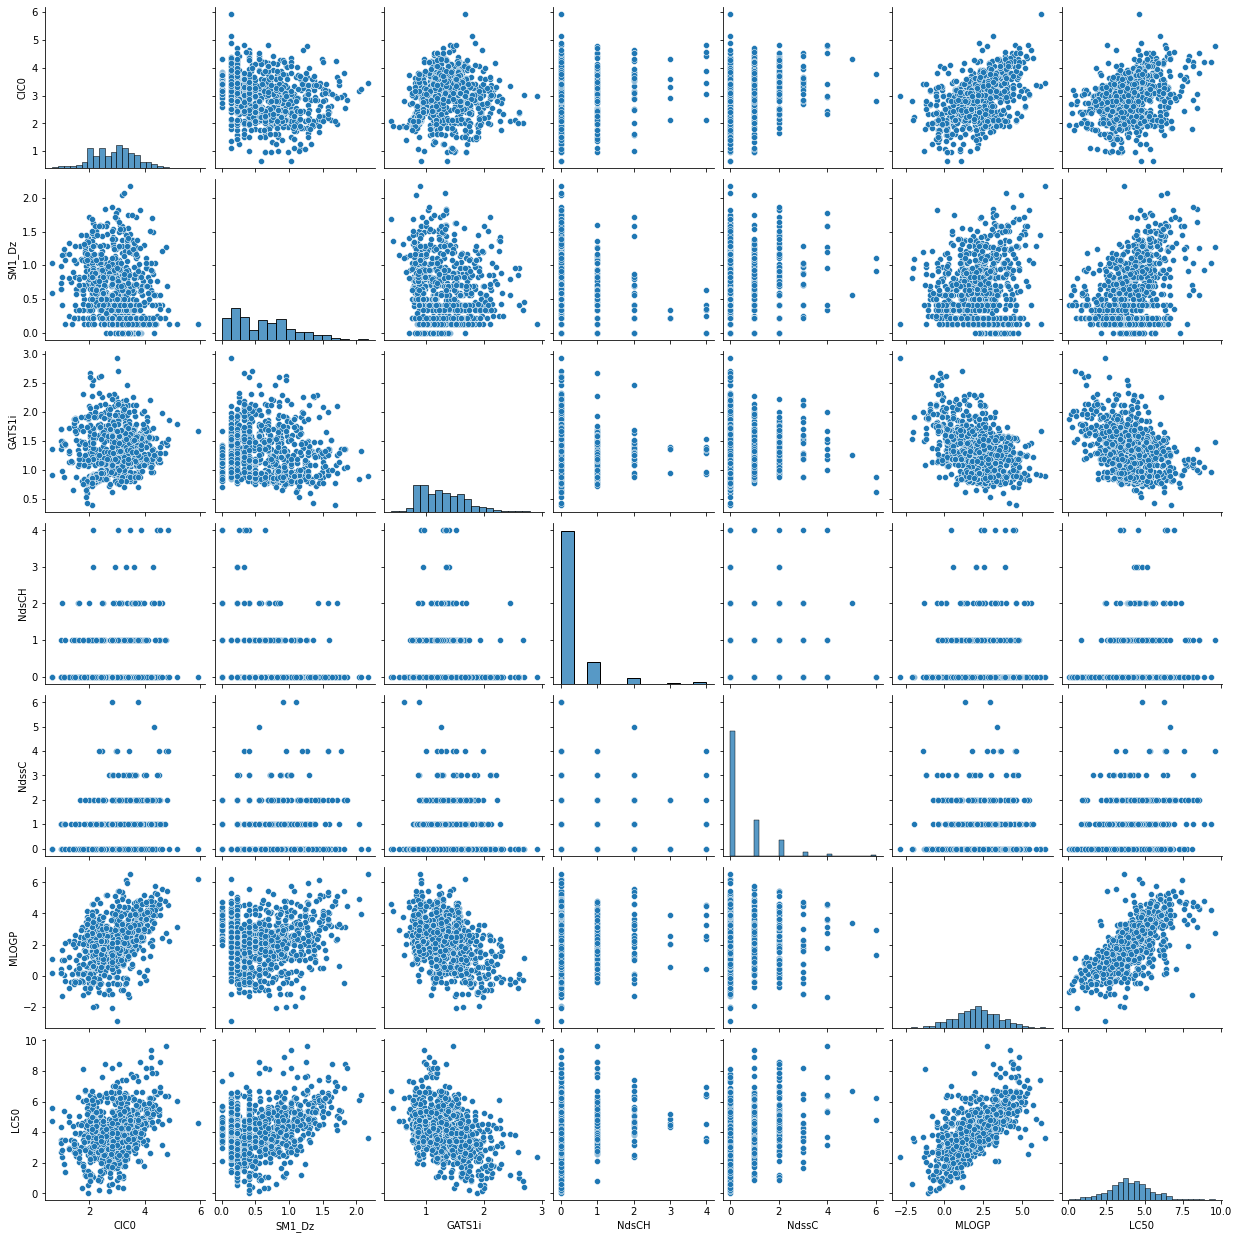

In [8]:
sns.pairplot(df)

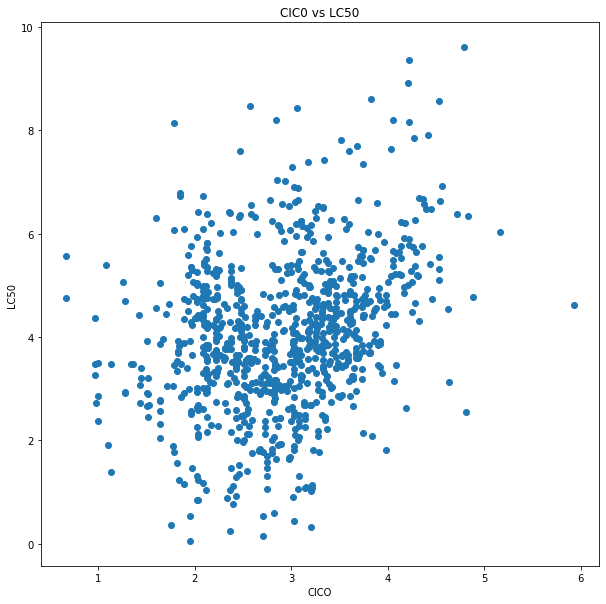

In [9]:
plt.figure(figsize = (10,10))
plot = plt.scatter(df["CIC0"], df["LC50"])
plt.xlabel("CICO")
plt.ylabel("LC50")
plt.title("CIC0 vs LC50")
plt.show()

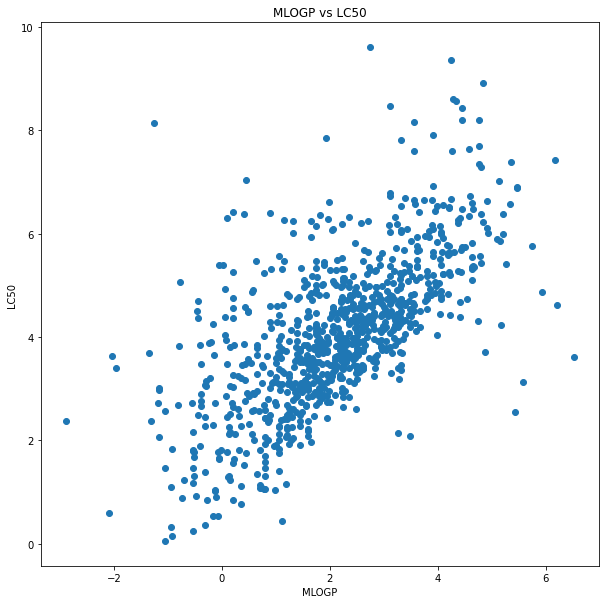

In [10]:
plt.figure(figsize = (10,10))
plot = plt.scatter(df["MLOGP"], df["LC50"])
plt.xlabel("MLOGP")
plt.ylabel("LC50")
plt.title("MLOGP vs LC50")
plt.show()

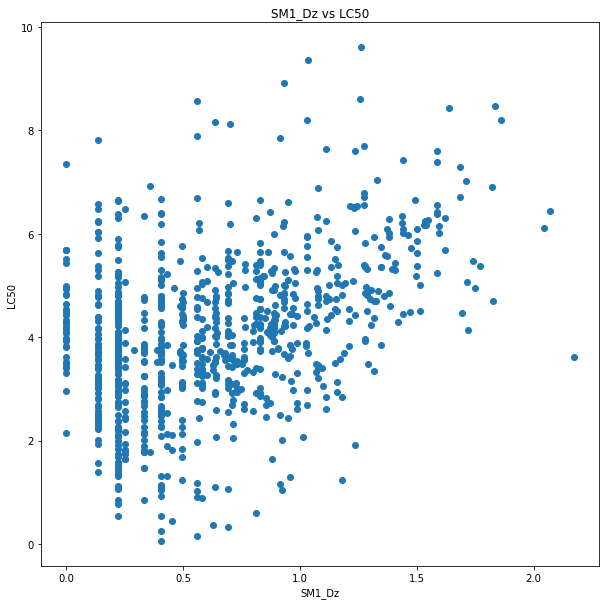

In [11]:
plt.figure(figsize = (10,10))
plot = plt.scatter(df["SM1_Dz"], df["LC50"])
plt.xlabel("SM1_Dz")
plt.ylabel("LC50")
plt.title("SM1_Dz vs LC50")
plt.show()

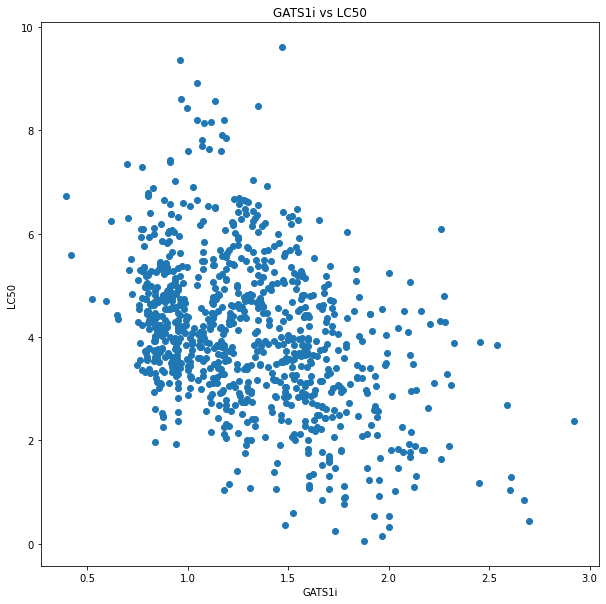

In [12]:
plt.figure(figsize = (10,10))
plot = plt.scatter(df["GATS1i"], df["LC50"])
plt.xlabel("GATS1i")
plt.ylabel("LC50")
plt.title("GATS1i vs LC50")
plt.show()

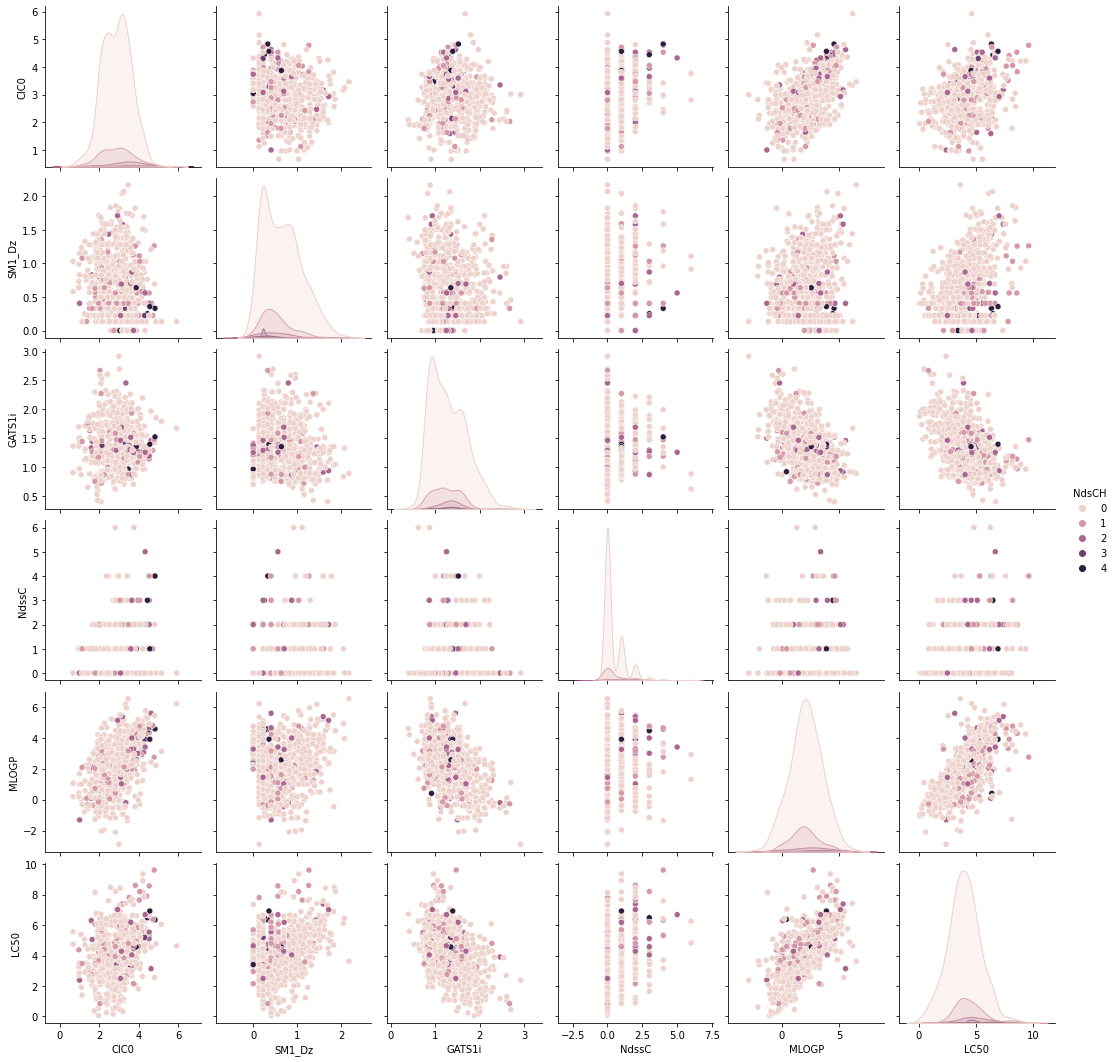

In [13]:
sns.pairplot(df, hue = "NdsCH")

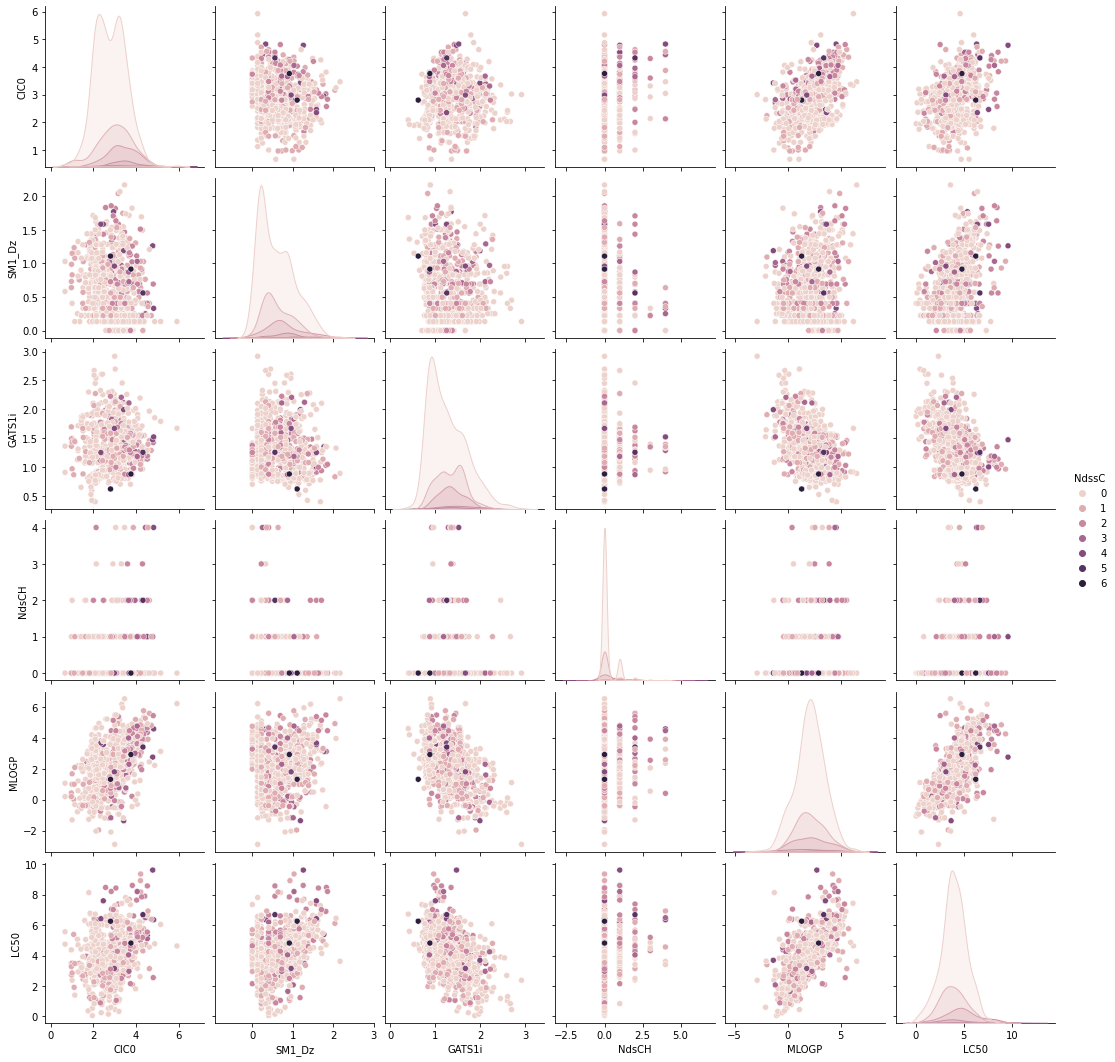

In [14]:
sns.pairplot(df, hue = "NdssC")

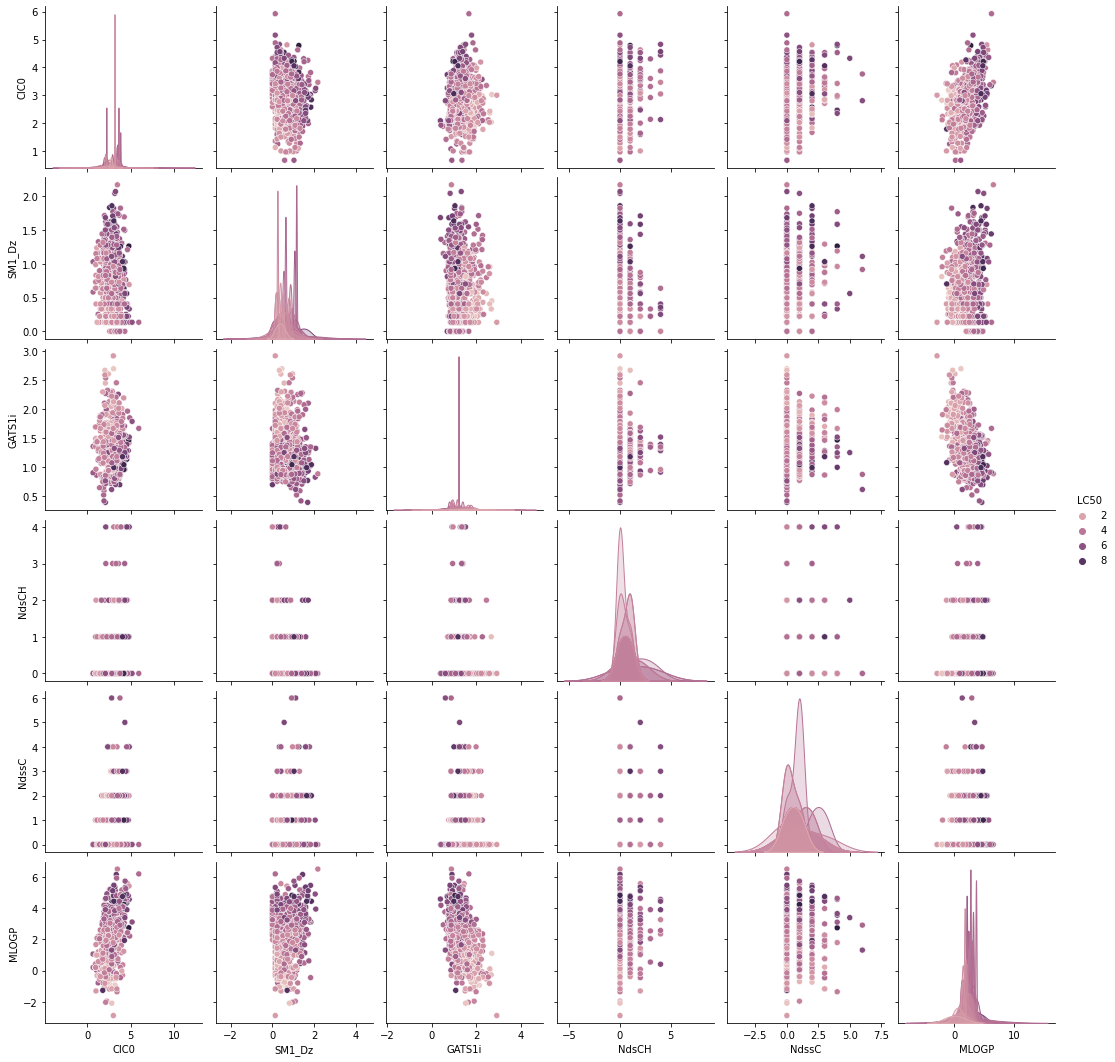

In [15]:
sns.pairplot(df, hue = "LC50")

[Text(0.5, 1.0, 'Correlation Matrix')]

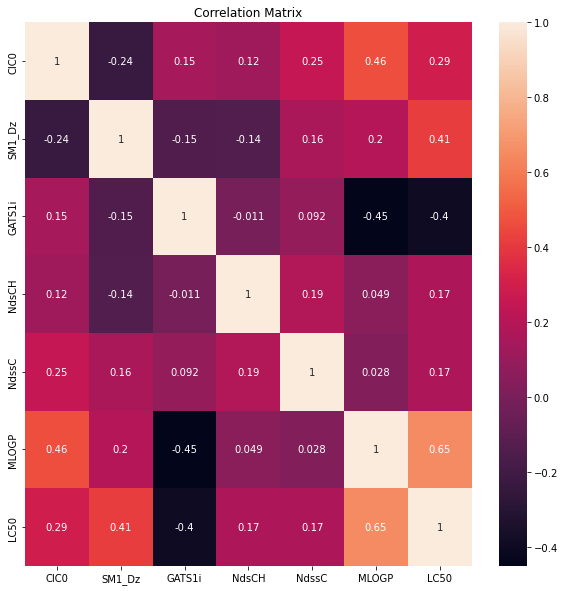

In [16]:
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True).set(title = "Correlation Matrix")

# Normalize, Split the Data, and Perform Dimensionality Reduction

In [17]:
X = df.iloc[:, 0:6]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = df
df_scaled.iloc[:, 0:6] = X_scaled
Train, Test = train_test_split(df_scaled, test_size=0.2, random_state=101)
X_test = Test.iloc[:, 0:6]
y_test = Test.iloc[:, 6:]
X_train = Train.iloc[:, 0:6]
y_train = Train.iloc[:, 6:]

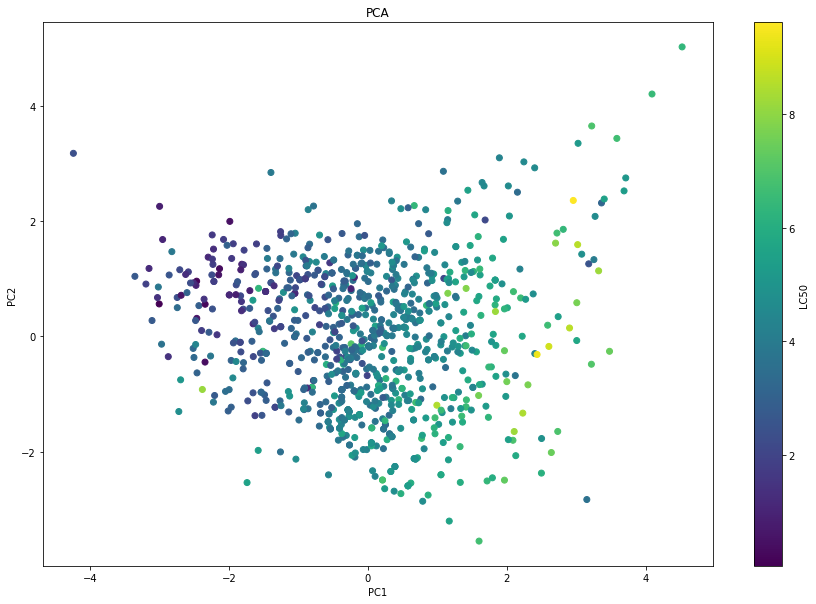

In [81]:
plt.figure(figsize = (15,10))
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
plot = plt.scatter(pc[:,0], pc[:,1], c=df.iloc[:, 6:].values)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
plt.colorbar(plot, label = "LC50")
plt.show()

In [74]:
reducer = umap.UMAP(target_metric='l1', random_state=101)
embedding = reducer.fit_transform(X_scaled, y = df.iloc[:, 6:].values)

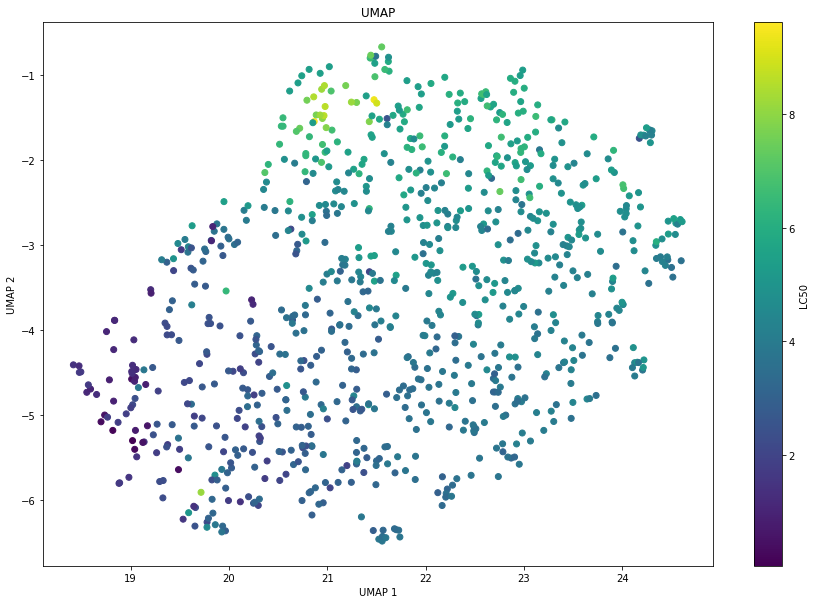

In [75]:
plt.figure(figsize = (15,10))
plot = plt.scatter(embedding[:,0], embedding[:,1], c=df.iloc[:, 6:].values)
plt.title("UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(plot, label = "LC50")
plt.show()

# Univariate Model Exploration

## CIC0 vs LC50

In [15]:
mod = smf.ols(formula = "LC50~CIC0", data = Train).fit()
print(mod.summary())
table = sm.stats.anova_lm(mod, typ=1)
print(table)
y_pred = mod.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     79.97
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           3.14e-18
Time:                        13:00:21   Log-Likelihood:                -1257.0
No. Observations:                 726   AIC:                             2518.
Df Residuals:                     724   BIC:                             2527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0056      0.051     78.850      0.0

## SM1_Dz vs LC50

In [16]:
mod = smf.ols(formula = "LC50~SM1_Dz", data = Train).fit()
print(mod.summary())
table = sm.stats.anova_lm(mod, typ=1)
print(table)
y_pred = mod.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     129.0
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           1.25e-27
Time:                        13:00:21   Log-Likelihood:                -1235.6
No. Observations:                 726   AIC:                             2475.
Df Residuals:                     724   BIC:                             2484.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0165      0.049     81.432      0.0

## GATS1i vs LC50

In [17]:
mod = smf.ols(formula = "LC50~GATS1i", data = Train).fit()
print(mod.summary())
table = sm.stats.anova_lm(mod, typ=1)
print(table)
y_pred = mod.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     118.7
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           1.07e-25
Time:                        13:00:21   Log-Likelihood:                -1240.0
No. Observations:                 726   AIC:                             2484.
Df Residuals:                     724   BIC:                             2493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0170      0.050     80.946      0.0

## NdsCH vs LC50

In [18]:
mod = smf.ols(formula = "LC50~NdsCH", data = Train).fit()
print(mod.summary())
table = sm.stats.anova_lm(mod, typ=1)
print(table)
y_pred = mod.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     26.32
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           3.73e-07
Time:                        13:00:21   Log-Likelihood:                -1282.1
No. Observations:                 726   AIC:                             2568.
Df Residuals:                     724   BIC:                             2577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0059      0.053     76.178      0.0

## NdssC vs LC50

In [19]:
mod = smf.ols(formula = "LC50~NdssC", data = Train).fit()
print(mod.summary())
table = sm.stats.anova_lm(mod, typ=1)
print(table)
y_pred = mod.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     17.03
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           4.10e-05
Time:                        13:00:21   Log-Likelihood:                -1286.6
No. Observations:                 726   AIC:                             2577.
Df Residuals:                     724   BIC:                             2586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0051      0.053     75.686      0.0

## MLOGP vs LC50

In [20]:
mod = smf.ols(formula = "LC50~MLOGP", data = Train).fit()
print(mod.summary())
table = sm.stats.anova_lm(mod, typ=1)
print(table)
y_pred = mod.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     531.3
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           1.38e-88
Time:                        13:00:21   Log-Likelihood:                -1095.3
No. Observations:                 726   AIC:                             2195.
Df Residuals:                     724   BIC:                             2204.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0443      0.041     99.405      0.0

# Model Exploration

## Multivariate Model with Every Factor

In [26]:
mod_1 = smf.ols(formula = "LC50~(CIC0+SM1_Dz+GATS1i+NdsCH+NdssC+MLOGP)", data = Train).fit()
print(mod_1.summary())
table = sm.stats.anova_lm(mod_1, typ=1)
print(table)
variables = mod_1.model.exog
y_pred = mod_1.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
cls = Linear_Reg_Diagnostic(mod_1)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     155.2
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          4.06e-126
Time:                        17:41:47   Log-Likelihood:                -993.50
No. Observations:                 726   AIC:                             2001.
Df Residuals:                     719   BIC:                             2033.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0379      0.036    113.732      0.0

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


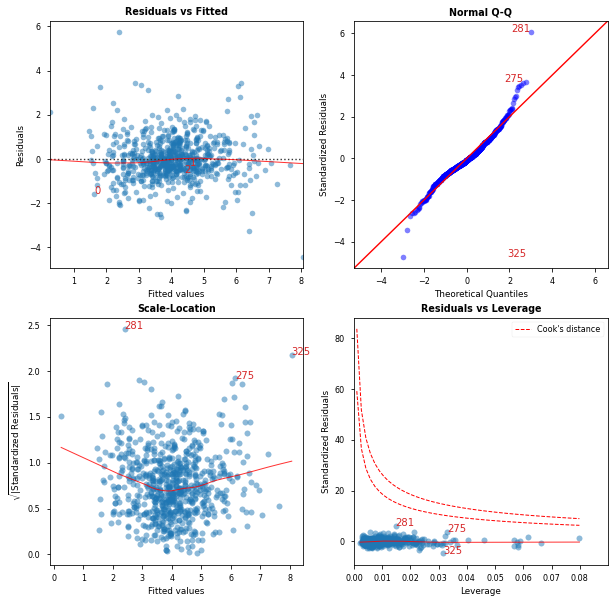

    Features  VIF Factor
0  Intercept        1.00
4      NdsCH        1.11
5      NdssC        1.26
2     SM1_Dz        1.33
3     GATS1i        1.64
1       CIC0        2.22
6      MLOGP        2.40


In [23]:
fig, ax = cls()

## Reduced Model

In [27]:
mod_2 = smf.ols(formula = "LC50~CIC0+SM1_Dz+GATS1i+NdsCH+MLOGP", data = Train).fit()
print(mod_2.summary())
table = sm.stats.anova_lm(mod_2, typ=1)
print(table)
table = sm.stats.anova_lm(mod_2,mod_1, typ=1)
print(table)
variables = mod_2.model.exog

y_pred = mod_2.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
cls = Linear_Reg_Diagnostic(mod_2)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     185.9
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          5.62e-127
Time:                        17:41:50   Log-Likelihood:                -994.20
No. Observations:                 726   AIC:                             2000.
Df Residuals:                     720   BIC:                             2028.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0381      0.036    113.707      0.0

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


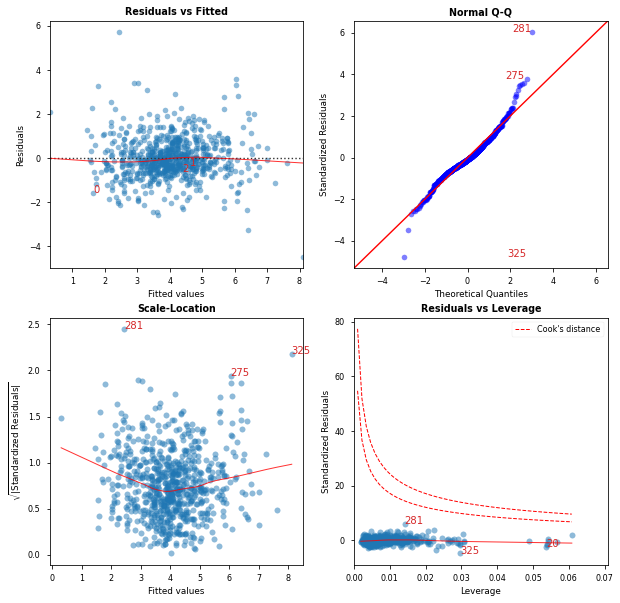

    Features  VIF Factor
0  Intercept        1.00
4      NdsCH        1.04
2     SM1_Dz        1.22
3     GATS1i        1.64
1       CIC0        1.98
5      MLOGP        2.30


In [28]:
fig, ax = cls()

# Interaction Testing

## All First Order Interaction Terms

In [29]:
mod_3 = smf.ols(formula = "LC50~(CIC0+SM1_Dz+GATS1i+NdsCH+NdssC+MLOGP)*(CIC0+SM1_Dz+GATS1i+NdsCH+NdssC+MLOGP)", data = Train).fit()
print(mod_3.summary())
table = sm.stats.anova_lm(mod_3, typ=1)
print(table)
variables = mod_3.model.exog
y_pred = mod_3.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
cls = Linear_Reg_Diagnostic(mod_3)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     53.42
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          3.18e-130
Time:                        17:42:28   Log-Likelihood:                -949.12
No. Observations:                 726   AIC:                             1942.
Df Residuals:                     704   BIC:                             2043.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.8885      0.049     79.473

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


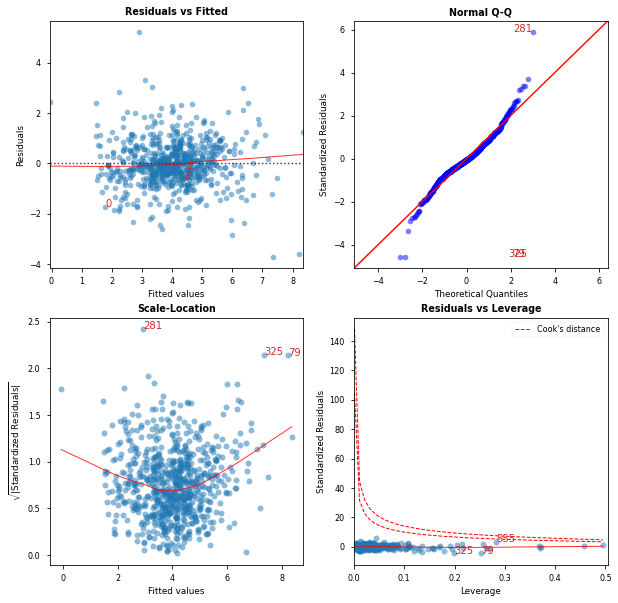

         Features  VIF Factor
11     CIC0:MLOGP        1.35
14   SM1_Dz:NdssC        1.47
16   GATS1i:NdsCH        1.64
2          SM1_Dz        1.64
17   GATS1i:NdssC        1.68
8     CIC0:GATS1i        1.72
13   SM1_Dz:NdsCH        1.78
18   GATS1i:MLOGP        1.81
12  SM1_Dz:GATS1i        1.93
7     CIC0:SM1_Dz        2.10
0       Intercept        2.11
4           NdsCH        2.16
3          GATS1i        2.21
5           NdssC        2.22
19    NdsCH:NdssC        2.60
15   SM1_Dz:MLOGP        2.71
21    NdssC:MLOGP        2.72
10     CIC0:NdssC        2.99
1            CIC0        3.28
6           MLOGP        3.97
20    NdsCH:MLOGP        5.49
9      CIC0:NdsCH        7.53


In [30]:
fig, ax = cls()

## Reduced Interactions Model

In [24]:
mod_4 = smf.ols(formula = "LC50~CIC0+SM1_Dz+GATS1i+NdsCH+MLOGP+CIC0:NdssC+CIC0:MLOGP+SM1_Dz:NdssC+NdsCH:MLOGP", data = Train).fit()
print(mod_4.summary())
table = sm.stats.anova_lm(mod_4, typ=1)
print(table)
table = sm.stats.anova_lm(mod_4,mod_3, typ=1)
print(table)
variables = mod_4.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
print(vif)
y_pred = mod_4.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
cls = Linear_Reg_Diagnostic(mod_4)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     121.0
Date:                Wed, 27 Jul 2022   Prob (F-statistic):          2.44e-137
Time:                        13:00:21   Log-Likelihood:                -959.51
No. Observations:                 726   AIC:                             1939.
Df Residuals:                     716   BIC:                             1985.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9337      0.038    103.544   

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


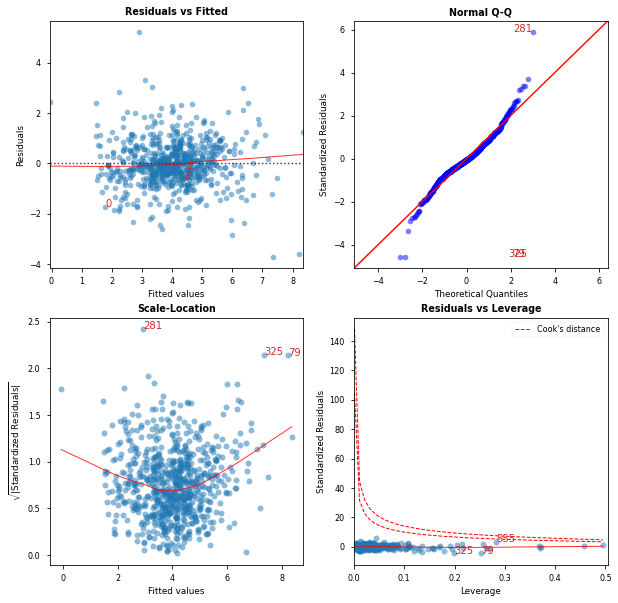

         Features  VIF Factor
11     CIC0:MLOGP        1.35
14   SM1_Dz:NdssC        1.47
16   GATS1i:NdsCH        1.64
2          SM1_Dz        1.64
17   GATS1i:NdssC        1.68
8     CIC0:GATS1i        1.72
13   SM1_Dz:NdsCH        1.78
18   GATS1i:MLOGP        1.81
12  SM1_Dz:GATS1i        1.93
7     CIC0:SM1_Dz        2.10
0       Intercept        2.11
4           NdsCH        2.16
3          GATS1i        2.21
5           NdssC        2.22
19    NdsCH:NdssC        2.60
15   SM1_Dz:MLOGP        2.71
21    NdssC:MLOGP        2.72
10     CIC0:NdssC        2.99
1            CIC0        3.28
6           MLOGP        3.97
20    NdsCH:MLOGP        5.49
9      CIC0:NdsCH        7.53


In [31]:
fig, ax = cls()

# Evaluation of Linear Models
There doesn't seem to be much good performance with Linear Models on this dataset. While the model with all first order interaction terms did perform the best, it may be due to there being more features. There was no significance between both reduced models and their respective parent model. The models with interaciton terms had less MAE, but had worse MSE, meaning errors may be bigger when interaction terms are included. $R^2$ on the test data for the models without interaction was higher as well. It is unlikely that interaction is present. Assumptions for linear regression hold for each model.

# KNN Regression

## KNN Example 6 Neighbors

In [32]:
knn1 = KNeighborsRegressor(n_neighbors=6)
knn1.fit(X_train, y_train)
knn1.score(X_test, y_test)
y_pred = knn1.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.5972747252747254
MSE: 0.7172062567155068
RMSE: 0.8468803083762821
R_squared: 0.6770962202216795


## Grid Search Optimization for KNN

In [33]:
scoring = {"MSE": "neg_mean_squared_error", "R2":"r2"}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors": range(1, 6), "weights":["uniform","distance"], "p":[1,2]},
    scoring=scoring,
    refit="MSE",
    return_train_score=True,
    n_jobs = -1,
    cv = 100,
    verbose = 3
)
gs.fit(X_train, y_train)
results = gs.cv_results_

Fitting 100 folds for each of 20 candidates, totalling 2000 fits


In [34]:
gs.best_params_

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [35]:
knn = gs.best_estimator_

In [36]:
y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.549976177393366
MSE: 0.6426008012295652
RMSE: 0.8016238527074685
R_squared: 0.7106854190650043


## PCA and KNN

In [28]:
def get_models():
    models = dict()
    for i in range(1,7):
        steps = [('pca', PCA(n_components=i)), ('m', KNeighborsRegressor(n_neighbors=5, p = 1, weights = "distance"))]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, random_state=101, shuffle = True)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>1 -1.738 (0.114)
>2 -1.161 (0.140)
>3 -0.950 (0.105)
>4 -0.812 (0.157)
>5 -0.866 (0.141)
>6 -0.847 (0.148)


In [29]:
steps = [('pca', PCA(n_components=4)), ('m', KNeighborsRegressor(n_neighbors=5, p = 1, weights = "distance"))]
model = Pipeline(steps=steps)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.5937420511872225
MSE: 0.7569008399616851
RMSE: 0.8700004827364667
R_squared: 0.6592247490139198


# Evaluation of KNN
KNN improves performance on the Test dataset. It was optimized, and led to a higher $R^2$ score and lower $MSE$. PCA compresses the data too much and does not allow for meaningful relationships to be seen by the model. KNN with 5 neighbors, l1 distance performs the best on the data.

# Gradient Descent

In [30]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty="l2", eta0=0.01)
sgd_reg.fit(X_train, y_train.values.ravel())
sgd_reg.intercept_, sgd_reg.coef_
y_pred = sgd_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.6641009021334089
MSE: 0.8673091952076947
RMSE: 0.931294365497663
R_squared: 0.6095162099510966


# Evaluation of Gradient Descent
Same performance as linear model but is outperformed by KNN. Cant be optimized as well since parameters are continuous

# 11. Ridge, Lasso, and Elasticnet Regularization

## Ridge Regression

In [39]:
poly = PolynomialFeatures(2)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
ridge_reg = Ridge(alpha=1 , solver= "auto")
ridge_reg.fit(poly_X_train , y_train)
y_pred= ridge_reg.predict(poly_X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.6192753750697797
MSE: 0.8440158736842909
RMSE: 0.9187033654473521
R_squared: 0.6200034324105659


In [62]:
intercept = ridge_reg.intercept_[0]
print("E(y) = " + str(intercept), end =" ")
i = 1
for coef in ridge_reg.coef_[0]:
    print("+ " + str(coef) + "*X_"+ str(i),end =" ")
    i+=1


E(y) = 3.892252012873493 + 0.0*X_1 + 0.3009287547124961*X_2 + 0.5846542581855313*X_3 + -0.2885722891861736*X_4 + 0.33561044270534446*X_5 + -0.04691621569339529*X_6 + 0.5147181910314026*X_7 + -0.011844581261028983*X_8 + -0.07988945669958426*X_9 + 0.0724036613395784*X_10 + -0.027615552497574667*X_11 + 0.17945067847378657*X_12 + 0.16240783769337988*X_13 + 0.04029647132214782*X_14 + 0.017151044825168892*X_15 + -0.005330546352793698*X_16 + 0.23548063628815477*X_17 + -0.07834081616696212*X_18 + 0.009090663384291042*X_19 + 0.014132939074507442*X_20 + -0.02385617257690637*X_21 + -0.013281152434592177*X_22 + -0.02893142065627501*X_23 + 0.06865771394750197*X_24 + -0.16582416385791565*X_25 + -0.0317079979197357*X_26 + -0.059135522124548326*X_27 + 0.0019317900535462068*X_28 

## Lasso Regression

In [65]:
lasso_reg = Lasso(alpha = 0.05)
lasso_reg.fit(poly_X_train, y_train)
y_pred = lasso_reg.predict(poly_X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.6531654769265813
MSE: 0.8695790137885683
RMSE: 0.9325122057048735
R_squared: 0.608494282169078


In [67]:
intercept = lasso_reg.intercept_[0]
print("E(y) = " + str(intercept), end =" ")
i = 1
for coef in lasso_reg.coef_:
    print("+ " + str(coef) + "*X_"+ str(i),end =" ")
    i+=1

E(y) = 3.9173103213192504 + 0.0*X_1 + 0.19886736243419062*X_2 + 0.4559465671701525*X_3 + -0.21256611454121532*X_4 + 0.18174835873080378*X_5 + 0.0*X_6 + 0.5931181518839378*X_7 + 0.04905532044355343*X_8 + -0.0*X_9 + 0.0*X_10 + -0.0*X_11 + 0.050231234305945914*X_12 + 0.04983652536927835*X_13 + 0.02268194583406715*X_14 + 0.0*X_15 + 0.0*X_16 + 0.09999300518796372*X_17 + -0.03501765577178401*X_18 + -0.0*X_19 + 0.0*X_20 + 0.0*X_21 + 0.0*X_22 + 0.0*X_23 + 0.017039571692934158*X_24 + -0.10798183174529531*X_25 + 0.011519941933311422*X_26 + 0.0*X_27 + 0.0*X_28 

## Elasticnet

In [68]:
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.01)
elastic_net.fit(poly_X_train, y_train)
y_pred = elastic_net.predict(poly_X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.6197670116899672
MSE: 0.8445688324608495
RMSE: 0.9190042613942818
R_squared: 0.6197544768592995


In [69]:
intercept = elastic_net.intercept_[0]
print("E(y) = " + str(intercept), end =" ")
i = 1
for coef in elastic_net.coef_:
    print("+ " + str(coef) + "*X_"+ str(i),end =" ")
    i+=1

E(y) = 3.8846309242680777 + 0.0*X_1 + 0.2927933522346351*X_2 + 0.5701587565393743*X_3 + -0.2853155296133328*X_4 + 0.3232608010829245*X_5 + -0.040683191849905674*X_6 + 0.5176625959975297*X_7 + -0.005686391706115492*X_8 + -0.07347373561585265*X_9 + 0.06744551223755198*X_10 + -0.026991311089282124*X_11 + 0.17140210905060943*X_12 + 0.1489001291691723*X_13 + 0.04387944907565253*X_14 + 0.015432694442330381*X_15 + -0.003522939339889553*X_16 + 0.22665360496982379*X_17 + -0.07987184434323709*X_18 + 0.010778170793633652*X_19 + 0.015419767927768628*X_20 + -0.019190216994567962*X_21 + -0.004776018749484832*X_22 + -0.026267038845699857*X_23 + 0.06587236709111102*X_24 + -0.16512229677517617*X_25 + -0.029005690231739913*X_26 + -0.05148489107405104*X_27 + 0.008550690699392257*X_28 

# Evaluation of Regularization
Slight improvement, but not as good as KNN

# Ridge, Lasso, and Elasticnet Regularization

In [74]:
scoring = {"MSE": "neg_mean_squared_error", "R2":"r2"}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    RandomForestRegressor(),
    param_grid={"n_estimators": [10,25,30,50,100,200], "max_depth":[2,3,5,10,20], "min_samples_leaf":[5,10,20,50,100,200]},
    scoring=scoring,
    refit="MSE",
    return_train_score=True,
    n_jobs = -1,
    cv = 20,
    verbose = 3
)
gs.fit(X_train, y_train.values.ravel())
results = gs.cv_results_

Fitting 20 folds for each of 180 candidates, totalling 3600 fits


In [75]:
gs.best_params_

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 50}

In [76]:
rf = gs.best_estimator_

In [77]:
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

MAE: 0.6061146426280116
MSE: 0.7715916605381403
RMSE: 0.8784029033069849
R_squared: 0.6526105826597295


# Evaluation of Random Forest Regression

Allows for the learning of nonlinear trends, increases in performance compared to linear models and regularization techniques, indicating there is a nonlinear trend in the data.

# Neural Network Regression

In [268]:
NN_model = Sequential()

NN_model.add(Dense(64, kernel_initializer='normal',input_dim = 6, activation='relu'))

NN_model.add(Dense(64, kernel_initializer='normal',activation='tanh'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='tanh'))
NN_model.add(Dense(64, kernel_initializer='normal',activation='tanh'))
NN_model.add(Dense(32, kernel_initializer='normal',activation='tanh'))

NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
NN_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_167 (Dense)           (None, 64)                448       
                                                                 
 dense_168 (Dense)           (None, 64)                4160      
                                                                 
 dense_169 (Dense)           (None, 128)               8320      
                                                                 
 dense_170 (Dense)           (None, 64)                8256      
                                                                 
 dense_171 (Dense)           (None, 32)                2080      
                                                                 
 dense_172 (Dense)           (None, 1)                 33        
                                                                 
Total params: 23,297
Trainable params: 23,297
Non-tra

In [269]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 3, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [270]:
with tf.device('/CPU:0'):
    NN_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_split = 0.2, callbacks=callbacks_list,verbose = 0)


Epoch 1: val_loss improved from inf to 0.93916, saving model to Weights-001--0.93916.hdf5

Epoch 2: val_loss improved from 0.93916 to 0.88233, saving model to Weights-002--0.88233.hdf5

Epoch 3: val_loss did not improve from 0.88233

Epoch 4: val_loss improved from 0.88233 to 0.84274, saving model to Weights-004--0.84274.hdf5

Epoch 5: val_loss did not improve from 0.84274

Epoch 6: val_loss improved from 0.84274 to 0.82479, saving model to Weights-006--0.82479.hdf5

Epoch 7: val_loss did not improve from 0.82479

Epoch 8: val_loss did not improve from 0.82479

Epoch 9: val_loss did not improve from 0.82479

Epoch 10: val_loss improved from 0.82479 to 0.78585, saving model to Weights-010--0.78585.hdf5

Epoch 11: val_loss improved from 0.78585 to 0.76202, saving model to Weights-011--0.76202.hdf5

Epoch 12: val_loss did not improve from 0.76202

Epoch 13: val_loss did not improve from 0.76202

Epoch 14: val_loss improved from 0.76202 to 0.75242, saving model to Weights-014--0.75242.hdf

In [272]:
weights_file = 'Weights-040--0.71186.hdf5' # choose the best checkpoint 
NN_model.load_weights(weights_file) # load it
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [273]:
y_pred = NN_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)
print("MAE: {}\nMSE: {}\nRMSE: {}\nR_squared: {}".format(mae, mse, rmse, r2))

6/6 [==============================] - 0s 3ms/step
MAE: 0.5881101118706086
MSE: 0.7509005102090602
RMSE: 0.8665451576283029
R_squared: 0.6619262440704632


# Evaluation of Neural Network

Took a while to train, but negligible increase in performance compared to the random forest and worse performance than KNN. Distance based modeling is a neccessity in this case.